# Figure 5: Regional-average SST Skill (correlation & RMSE)

In [2]:
%load_ext autoreload
%autoreload 2
import xarray as xr 
import numpy as np  
import cftime
import copy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xesmf as xe
%matplotlib inline

# import plotting and other utilities from SMYLEutils
from SMYLEutils import calendar_utils as cal
from SMYLEutils import mapplot_utils as maps
from SMYLEutils import colorbar_utils as cbars
from SMYLEutils import regrid_utils as regrid

# import ESP-Lab modules
from esp_lab import data_access
from esp_lab import stats

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import dask
from dask.distributed import wait
dask.__version__

'2021.09.0'

## Start Dask Cluster

In [38]:
# Close out Dask Cluster and release workers:
# NOTE:  only run this cell to terminate Dask Cluster!
cluster.close()
client.close()

In [4]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='20GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=20GB',
        project='NCGD0011',
        walltime='02:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status',
        'array.slicing.split_large_chunks':True
    })
    client = Client(cluster)
    return cluster, client

In [5]:
cluster, client = get_ClusterClient()
cluster.scale(30) 

/glade/work/yeager/miniconda3/envs/smyle-analysis/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36459 instead
  warnings.warn(


In [6]:
cluster

### Read in POP monthly SST data using I/O functions; Convert to seasonal mean

In [7]:
# This preprocessor will return POP SST (first vertical grid level only)
def preprocessor(d0,nlead,field):
    """ This preprocessor is applied on an individual timeseries file basis. Edit this appropriately
    for your analysis to speed up processing. 
    
    Here,
        - reset monthly time to mid-month value
        - select top vertical level and only nlead time values
        - drop fields unrelated to SST
    """
    d0 = cal.time_set_midmonth(d0,'time')
    d0 = d0.isel(z_t=0).isel(time=slice(0, nlead))
    d0 = d0.assign_coords(L=("time", np.arange(d0.sizes["time"])+1))
    d0 = d0.swap_dims({"time": "L"})
    d0 = d0.reset_coords(["time"])
    d0["time"] = d0.time.expand_dims("Y")
    d0 = d0[[field,'time','TLAT','TLONG','TAREA']].drop(['ULAT','ULONG'])
    d0 = d0.chunk({'L':-1})
    return d0

In [8]:
%%time
# SMYLE-Nov SST data
# process all 20 ensemble members, all November start dates from 1970-2019:
field = 'TEMP'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.pop.h.'
filetemplate = datadir+casename+'/ocn/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
inityears = np.arange(1970,2020,1)
startmonth = 11
chunk = {}
smyle11 = data_access.get_monthly_data(filetemplate,filetype,ens,nlead,field,inityears,startmonth,preprocessor,chunks=chunk)
smyle11.nbytes/1e9 #GB

CPU times: user 27.3 s, sys: 12.2 s, total: 39.5 s
Wall time: 1min 12s


11.799439476

In [9]:
%%time
smyle11_seas = cal.mon_to_seas_dask(smyle11).persist()
daskout = wait(smyle11_seas)

CPU times: user 57.9 s, sys: 1.49 s, total: 59.4 s
Wall time: 1min 42s


In [10]:
%%time
# SMYLE-Feb SST data
# process all 20 ensemble members, all February start dates from 1970-2019:
field = 'TEMP'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.pop.h.'
filetemplate = datadir+casename+'/ocn/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
inityears = np.arange(1970,2020,1)
startmonth = 2
chunk = {}
smyle02 = data_access.get_monthly_data(filetemplate,filetype,ens,nlead,field,inityears,startmonth,preprocessor,chunks=chunk)
smyle02.nbytes/1e9 #GB

CPU times: user 31.7 s, sys: 12.1 s, total: 43.7 s
Wall time: 1min 16s


11.799439476

In [11]:
%%time
smyle02_seas = cal.mon_to_seas_dask(smyle02).persist()
daskout = wait(smyle02_seas)

CPU times: user 1min 5s, sys: 1.48 s, total: 1min 6s
Wall time: 1min 44s


In [12]:
%%time
# SMYLE-May SST data
# process all 20 ensemble members, all May start dates from 1970-2019:
field = 'TEMP'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.pop.h.'
filetemplate = datadir+casename+'/ocn/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
inityears = np.arange(1970,2020,1)
startmonth = 5
chunk = {}
smyle05 = data_access.get_monthly_data(filetemplate,filetype,ens,nlead,field,inityears,startmonth,preprocessor,chunks=chunk)
smyle05.nbytes/1e9 #GB

CPU times: user 37.3 s, sys: 12.7 s, total: 50 s
Wall time: 1min 22s


11.799439476

In [13]:
%%time
smyle05_seas = cal.mon_to_seas_dask(smyle05).persist()
daskout = wait(smyle05_seas)

CPU times: user 1min 6s, sys: 1.5 s, total: 1min 8s
Wall time: 1min 40s


In [14]:
%%time
# SMYLE-Aug SST data
# process all 20 ensemble members, all August start dates from 1970-2019:
field = 'TEMP'
datadir = '/glade/campaign/cesm/development/espwg/SMYLE/archive/'
casename = 'b.e21.BSMYLE.f09_g17.????-MM.EEE'
filetype = '.pop.h.'
filetemplate = datadir+casename+'/ocn/proc/tseries/month_1/'+casename+filetype+field+'.*.nc'
ens = 20 
nlead = 24
inityears = np.arange(1970,2020,1)
startmonth = 8
chunk = {}
smyle08 = data_access.get_monthly_data(filetemplate,filetype,ens,nlead,field,inityears,startmonth,preprocessor,chunks=chunk)
smyle08.nbytes/1e9 #GB

CPU times: user 41 s, sys: 12 s, total: 53 s
Wall time: 1min 24s


11.799439476

In [15]:
%%time
smyle08_seas = cal.mon_to_seas_dask(smyle08).persist()
daskout = wait(smyle08_seas)

CPU times: user 1min 12s, sys: 1.57 s, total: 1min 13s
Wall time: 1min 44s


# Compute Regional-average SST

### Define Averaging Regions

In [16]:
region1lonlat = [-20.,0.,-3.,3.]  
region1title = 'Atlantic Nino'

region2lonlat = [-80.,-10.,10.,20.]  
region2title = 'Atlantic MDR'

region3lonlat = [50.,70.,-10.,10.]    # IOD-west, to be overwritten by IOD
region3title = 'Indian Ocean Dipole'

region4lonlat = [90.,110.,-10.,0.]  # IOD-east
region4title = 'IODe'

In [17]:
def POP_regional_areawgt(ds,lonlat):
    tarea = ds.TAREA
    tlat = ds.TLAT
    tlon = xr.where(ds.TLONG>180.,ds.TLONG-360.,ds.TLONG)
    region = (tlat>=lonlat[2]) & (tlat<=lonlat[3]) & (tlon>=lonlat[0]) & (tlon<=lonlat[1])
    return xr.where(region,tarea.fillna(0),0)

In [18]:
POPg16_reg1sst_area = POP_regional_areawgt(smyle11,region1lonlat)
POPg16_reg2sst_area = POP_regional_areawgt(smyle11,region2lonlat)
POPg16_reg3sst_area = POP_regional_areawgt(smyle11,region3lonlat)
POPg16_reg4sst_area = POP_regional_areawgt(smyle11,region4lonlat)

### Perform regional-average computation on SMYLE, returning xarray:

In [19]:
%%time
smyle11_seas_reg1sst = smyle11_seas.TEMP.weighted(POPg16_reg1sst_area).mean(("nlon", "nlat")).load()
smyle02_seas_reg1sst = smyle02_seas.TEMP.weighted(POPg16_reg1sst_area).mean(("nlon", "nlat")).load()
smyle05_seas_reg1sst = smyle05_seas.TEMP.weighted(POPg16_reg1sst_area).mean(("nlon", "nlat")).load()
smyle08_seas_reg1sst = smyle08_seas.TEMP.weighted(POPg16_reg1sst_area).mean(("nlon", "nlat")).load()

CPU times: user 2min 30s, sys: 2.74 s, total: 2min 32s
Wall time: 2min 41s


In [20]:
%%time
smyle11_seas_reg2sst = smyle11_seas.TEMP.weighted(POPg16_reg2sst_area).mean(("nlon", "nlat")).load()
smyle02_seas_reg2sst = smyle02_seas.TEMP.weighted(POPg16_reg2sst_area).mean(("nlon", "nlat")).load()
smyle05_seas_reg2sst = smyle05_seas.TEMP.weighted(POPg16_reg2sst_area).mean(("nlon", "nlat")).load()
smyle08_seas_reg2sst = smyle08_seas.TEMP.weighted(POPg16_reg2sst_area).mean(("nlon", "nlat")).load()

CPU times: user 2min 24s, sys: 2.06 s, total: 2min 26s
Wall time: 2min 34s


In [21]:
%%time
smyle11_seas_reg3sst = smyle11_seas.TEMP.weighted(POPg16_reg3sst_area).mean(("nlon", "nlat")).load()
smyle02_seas_reg3sst = smyle02_seas.TEMP.weighted(POPg16_reg3sst_area).mean(("nlon", "nlat")).load()
smyle05_seas_reg3sst = smyle05_seas.TEMP.weighted(POPg16_reg3sst_area).mean(("nlon", "nlat")).load()
smyle08_seas_reg3sst = smyle08_seas.TEMP.weighted(POPg16_reg3sst_area).mean(("nlon", "nlat")).load()

CPU times: user 2min 25s, sys: 2.1 s, total: 2min 27s
Wall time: 2min 38s


In [22]:
%%time
smyle11_seas_reg4sst = smyle11_seas.TEMP.weighted(POPg16_reg4sst_area).mean(("nlon", "nlat")).load()
smyle02_seas_reg4sst = smyle02_seas.TEMP.weighted(POPg16_reg4sst_area).mean(("nlon", "nlat")).load()
smyle05_seas_reg4sst = smyle05_seas.TEMP.weighted(POPg16_reg4sst_area).mean(("nlon", "nlat")).load()
smyle08_seas_reg4sst = smyle08_seas.TEMP.weighted(POPg16_reg4sst_area).mean(("nlon", "nlat")).load()

CPU times: user 2min 28s, sys: 2.05 s, total: 2min 30s
Wall time: 2min 39s


In [23]:
%%time
smyle11_seas_reg3sst = smyle11_seas_reg3sst - smyle11_seas_reg4sst
smyle02_seas_reg3sst = smyle02_seas_reg3sst - smyle02_seas_reg4sst
smyle05_seas_reg3sst = smyle05_seas_reg3sst - smyle05_seas_reg4sst
smyle08_seas_reg3sst = smyle08_seas_reg3sst - smyle08_seas_reg4sst

CPU times: user 3.47 ms, sys: 0 ns, total: 3.47 ms
Wall time: 3.9 ms


### Store datasets to disk for quicker processing next time 

In [24]:
%%time
smyle11_seas_time = smyle11_seas.time.load()
smyle02_seas_time = smyle02_seas.time.load()
smyle05_seas_time = smyle05_seas.time.load()
smyle08_seas_time = smyle08_seas.time.load()

CPU times: user 138 ms, sys: 5 ms, total: 143 ms
Wall time: 149 ms


In [29]:
# combine regional xarrays
regions= xr.DataArray([region1title,region2title,region3title],name='region',dims='region')

smyle11_seas = xr.concat([smyle11_seas_reg1sst,smyle11_seas_reg2sst,smyle11_seas_reg3sst],dim=regions)
smyle11_seas = smyle11_seas.drop('z_t').rename('sst')
ds_smyle11_seas = smyle11_seas.to_dataset()
ds_smyle11_seas['time'] = smyle11_seas_time

smyle02_seas = xr.concat([smyle02_seas_reg1sst,smyle02_seas_reg2sst,smyle02_seas_reg3sst],dim=regions)
smyle02_seas = smyle02_seas.drop('z_t').rename('sst')
ds_smyle02_seas = smyle02_seas.to_dataset()
ds_smyle02_seas['time'] = smyle02_seas_time

smyle05_seas = xr.concat([smyle05_seas_reg1sst,smyle05_seas_reg2sst,smyle05_seas_reg3sst],dim=regions)
smyle05_seas = smyle05_seas.drop('z_t').rename('sst')
ds_smyle05_seas = smyle05_seas.to_dataset()
ds_smyle05_seas['time'] = smyle05_seas_time

smyle08_seas = xr.concat([smyle08_seas_reg1sst,smyle08_seas_reg2sst,smyle08_seas_reg3sst],dim=regions)
smyle08_seas = smyle08_seas.drop('z_t').rename('sst')
ds_smyle08_seas = smyle08_seas.to_dataset()
ds_smyle08_seas['time'] = smyle08_seas_time

In [30]:
%%time
## Save Fig data to file:
outdir = '/glade/scratch/yeager/SMYLE_paper/'
ds_smyle11_seas.to_netcdf(outdir+'SMYLE11_regSST_seas.nc')
ds_smyle02_seas.to_netcdf(outdir+'SMYLE02_regSST_seas.nc')
ds_smyle05_seas.to_netcdf(outdir+'SMYLE05_regSST_seas.nc')
ds_smyle08_seas.to_netcdf(outdir+'SMYLE08_regSST_seas.nc')

CPU times: user 184 ms, sys: 13.6 ms, total: 198 ms
Wall time: 436 ms


In [ ]:
## Retrieve pre-saved Fig data:
outdir = '/glade/scratch/yeager/SMYLE_paper/'
ds_smyle11_seas = xr.open_dataset(outdir+'SMYLE11_regSST_seas.nc')
smyle11_seas_time = ds_smyle11_seas['time']
smyle11_seas = ds_smyle11_seas['sst']

ds_smyle02_seas = xr.open_dataset(outdir+'SMYLE02_regSST_seas.nc')
smyle02_seas_time = ds_smyle02_seas['time']
smyle02_seas = ds_smyle02_seas['sst']

ds_smyle05_seas = xr.open_dataset(outdir+'SMYLE05_regSST_seas.nc')
smyle05_seas_time = ds_smyle05_seas['time']
smyle05_seas = ds_smyle05_seas['sst']

ds_smyle08_seas = xr.open_dataset(outdir+'SMYLE08_regSST_seas.nc')
smyle08_seas_time = ds_smyle08_seas['time']
smyle08_seas = ds_smyle08_seas['sst']

### Compute observed seasonal SST anomalies

In [31]:
# HADISST  (1deg SST over ocean)
obs_dir = '/glade/campaign/cesm/development/espwg/verification_datasets/'
ds_hadisst = xr.open_dataset(obs_dir+'mon/SST/HadISST_sst.nc').sel(time=slice("1870","2020"))
nt = np.size(ds_hadisst.time)
hadisst_montime_vals = [cftime.DatetimeNoLeap(1870+year, 1+month, 15) for year in range(151) for month in range(12)]
ds_hadisst['time'] = hadisst_montime_vals
ds_hadisst['sst'] = xr.where(ds_hadisst['sst']<-2,-1.8,ds_hadisst['sst'])
ds_hadisst = ds_hadisst.sel(time=slice("1960","2020"))

In [32]:
# Note that latitude decreases with index in this dataset!
ds_hadisst = ds_hadisst.rename({"latitude":"lat","longitude":"lon"})
ds_hadisst = ds_hadisst.reindex(lat=ds_hadisst.lat[::-1])

In [35]:
# Region 1
tmp = ds_hadisst.sst.sel(lat=slice(region1lonlat[2],region1lonlat[3])).sel(lon=slice(region1lonlat[0],region1lonlat[1]))
wgts = np.cos(np.deg2rad(tmp.lat))
obs_reg1sst = tmp.weighted(wgts).mean(("lon", "lat")).rolling(time=3,min_periods=3, center=True).mean().dropna('time',how='all')

In [37]:
# Region 2
tmp = ds_hadisst.sst.sel(lat=slice(region2lonlat[2],region2lonlat[3])).sel(lon=slice(region2lonlat[0],region2lonlat[1]))
wgts = np.cos(np.deg2rad(tmp.lat))
obs_reg2sst = tmp.weighted(wgts).mean(("lon", "lat")).rolling(time=3,min_periods=3, center=True).mean().dropna('time',how='all')

In [38]:
# Region 3
tmp = ds_hadisst.sst.sel(lat=slice(region3lonlat[2],region3lonlat[3])).sel(lon=slice(region3lonlat[0],region3lonlat[1]))
wgts = np.cos(np.deg2rad(tmp.lat))
obs_reg3sst = tmp.weighted(wgts).mean(("lon", "lat")).rolling(time=3,min_periods=3, center=True).mean().dropna('time',how='all')

tmp = ds_hadisst.sst.sel(lat=slice(region4lonlat[2],region4lonlat[3])).sel(lon=slice(region4lonlat[0],region4lonlat[1]))
wgts = np.cos(np.deg2rad(tmp.lat))
obs_reg4sst = tmp.weighted(wgts).mean(("lon", "lat")).rolling(time=3,min_periods=3, center=True).mean().dropna('time',how='all')

obs_reg3sst = obs_reg3sst - obs_reg4sst 


In [40]:
obs_seas = xr.concat([obs_reg1sst,obs_reg2sst,obs_reg3sst],dim=regions)

# Skill Analysis

### Remove leadtime-dependent drift from SMYLE data:

In [39]:
%%time
# Remove leadtime-dependent climatology
climy0 = 1972
climy1 = 2018
smyle11_seas_dd,smyle11_seas_drift = stats.remove_drift(smyle11_seas,smyle11_seas_time,climy0,climy1)
smyle02_seas_dd,smyle02_seas_drift = stats.remove_drift(smyle02_seas,smyle02_seas_time,climy0,climy1)
smyle05_seas_dd,smyle05_seas_drift = stats.remove_drift(smyle05_seas,smyle05_seas_time,climy0,climy1)
smyle08_seas_dd,smyle08_seas_drift = stats.remove_drift(smyle08_seas,smyle08_seas_time,climy0,climy1)

CPU times: user 14.1 ms, sys: 9 µs, total: 14.1 ms
Wall time: 14.1 ms


In [42]:
%%time
# SMYLE seasonal skill
smyle11_seas_skill = stats.compute_skill_seasonal(smyle11_seas_dd,smyle11_seas_time,obs_seas,str(climy0),str(climy1),1,8,resamp=0,detrend=True)
smyle02_seas_skill = stats.compute_skill_seasonal(smyle02_seas_dd,smyle02_seas_time,obs_seas,str(climy0),str(climy1),1,8,resamp=0,detrend=True)
smyle05_seas_skill = stats.compute_skill_seasonal(smyle05_seas_dd,smyle05_seas_time,obs_seas,str(climy0),str(climy1),1,8,resamp=0,detrend=True)
smyle08_seas_skill = stats.compute_skill_seasonal(smyle08_seas_dd,smyle08_seas_time,obs_seas,str(climy0),str(climy1),1,8,resamp=0,detrend=True)


CPU times: user 1 s, sys: 6.19 ms, total: 1.01 s
Wall time: 1.06 s


# Plots

### Generate ACC and normalized RMSE Skill Plot

In [51]:
# combine skill score xarrays for plotting
startmonth= xr.DataArray([11,2,5,8],name='startmonth',dims='startmonth')
reg1_skill = xr.concat([smyle11_seas_skill.isel(region=0),smyle02_seas_skill.isel(region=0),smyle05_seas_skill.isel(region=0),smyle08_seas_skill.isel(region=0)],dim=startmonth)
reg2_skill = xr.concat([smyle11_seas_skill.isel(region=1),smyle02_seas_skill.isel(region=1),smyle05_seas_skill.isel(region=1),smyle08_seas_skill.isel(region=1)],dim=startmonth)
reg3_skill = xr.concat([smyle11_seas_skill.isel(region=2),smyle02_seas_skill.isel(region=2),smyle05_seas_skill.isel(region=2),smyle08_seas_skill.isel(region=2)],dim=startmonth)
reg_skill = xr.concat([reg1_skill,reg2_skill,reg3_skill],dim=regions)
reg_time = xr.concat([smyle11_seas_time,smyle02_seas_time,smyle05_seas_time,smyle08_seas_time],dim=startmonth)

In [54]:
reg_time.isel(startmonth=0,L=0).dt.month

<xarray.DataArray 'month' (Y: 50)>
array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1])
Coordinates:
    z_t         float32 500.0
    L           int64 3
  * Y           (Y) int64 1970 1971 1972 1973 1974 ... 2015 2016 2017 2018 2019
    startmonth  int64 11

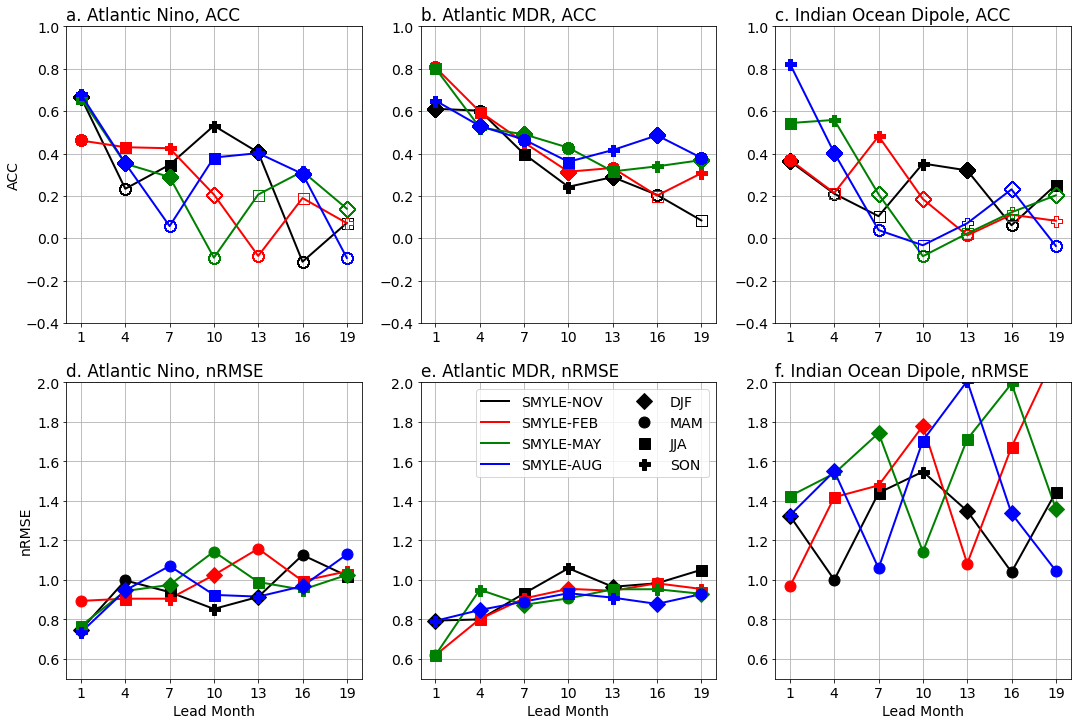

In [60]:
# plot skill scores
fig = plt.figure(figsize=(18,12))
plt.rcParams['font.size'] = '14'
leadmon = reg_skill.L-2
seasdict = {1:'DJF',4:'MAM',7:'JJA',10:'SON'}
seasmon = [1,4,7,10]
markers = ['D','o','s','P']
colors = ['k','r','g','b']
hindcasts = ['NOV','FEB','MAY','AUG']
figlabs = [['a.','b.','c.'],['d.','e.','f.']]

ncol = 3
nrow = 2

for i in range(ncol):
    ax = fig.add_subplot(nrow,ncol,i+1)
    if i==0: ax.set_ylabel('ACC', fontsize=14)
    ax.set_title(figlabs[0][i]+' {}, ACC'.format(reg_skill.isel(region=i).region.values),loc='left')
    for j in range(4):
        ax.plot(leadmon,reg_skill.isel(region=i,startmonth=j).corr,color=colors[j],linewidth=2,label='SMYLE-'+hindcasts[j])
        for k,l in zip(seasmon,markers):
            tmp = reg_skill.isel(region=i,startmonth=j)
            tmptime = reg_time.isel(startmonth=j)
            ax.plot(leadmon,tmp.corr.where(tmptime.dt.month==k),color=colors[j],marker=l,markersize=11,fillstyle='none')
            ax.plot(leadmon,tmp.corr.where(tmptime.dt.month==k).where(tmp.pval<0.1),color=colors[j],marker=l,markersize=11)
            
    ax.set_xticks(leadmon)
    ax.grid(True)
    ax.set_xlim([0,20])
    ax.set_ylim([-0.4,1])
        
    ax = fig.add_subplot(nrow,ncol,i+4)
    if i==0: ax.set_ylabel(r'nRMSE', fontsize=14)
    ax.set_title(figlabs[1][i]+' {}, nRMSE'.format(reg_skill.isel(region=i).region.values),loc='left')
    for j in range(4):
        ax.plot(leadmon,reg_skill.isel(region=i,startmonth=j).rmse,color=colors[j],linewidth=2,label='SMYLE-'+hindcasts[j])
    for j in range(4):
        for k,l in zip(seasmon,markers):
            tmp = reg_skill.isel(region=i,startmonth=j)
            tmptime = reg_time.isel(startmonth=j,Y=0)
            if j==0: ax.plot(leadmon,tmp.rmse.where(tmptime.dt.month==k),color=colors[j],marker=l,label=seasdict[k],markersize=11,linestyle='None')
            if j!=0: ax.plot(leadmon,tmp.rmse.where(tmptime.dt.month==k),color=colors[j],marker=l,markersize=11)
    if i==1: leg1 = ax.legend(loc='upper right',ncol=2)
    ax.set_xticks(leadmon)
    ax.set_xlabel('Lead Month')
    ax.grid(True)
    ax.set_xlim([0,20])
    ax.set_ylim([0.5,2])
    
plt.savefig('f05.png')